In [1]:
import numpy as np
import pandas as pd
pd.options.display.float_format = "{:,.4f}".format

import statsmodels.api as sm
from scipy.signal import convolve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import date, datetime

# Read data

In [2]:
df_sales = pd.read_csv('data/data_weekly.csv')
df_economy = pd.read_csv('data/data_monthly.csv')

In [3]:
df_sales.info()
df_sales.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Date                      117 non-null    object 
 1   investment_tv             117 non-null    float64
 2   investment_radio          117 non-null    float64
 3   investment_press          117 non-null    float64
 4   investment_banners        117 non-null    float64
 5   investment_online         117 non-null    float64
 6   stores_opened             117 non-null    int64  
 7   economy_index             117 non-null    float64
 8   investment_competition    117 non-null    float64
 9   public_holidays           117 non-null    int64  
 10  brand_knowledge           117 non-null    float64
 11  christmas_dummy           117 non-null    int64  
 12  weather_index             117 non-null    float64
 13  investment_competition_1  117 non-null    float64
 14  investment

(117, 20)

In [4]:
df_economy.info()
df_economy.shape
# cool, we have clean data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          36 non-null     object 
 1   unemployment  36 non-null     float64
 2   tourists      36 non-null     int64  
 3   gdp           36 non-null     float64
 4   confidence    36 non-null     float64
dtypes: float64(3), int64(1), object(1)
memory usage: 1.5+ KB


(36, 5)

## Step 1. Creating an overview of my client's business.

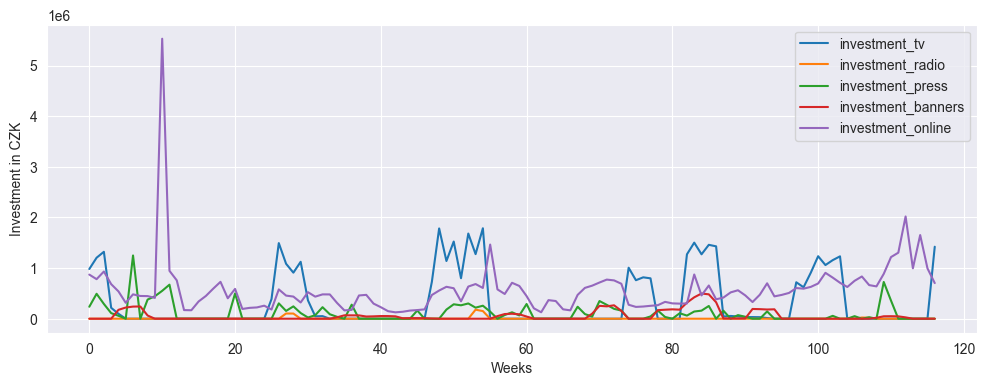

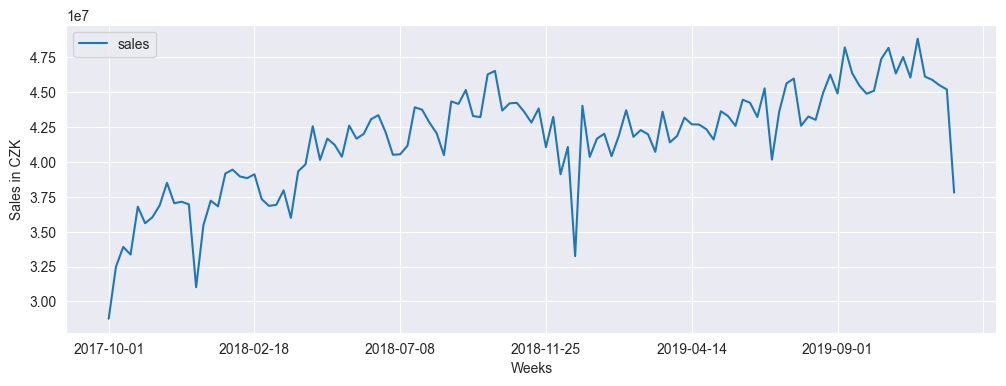

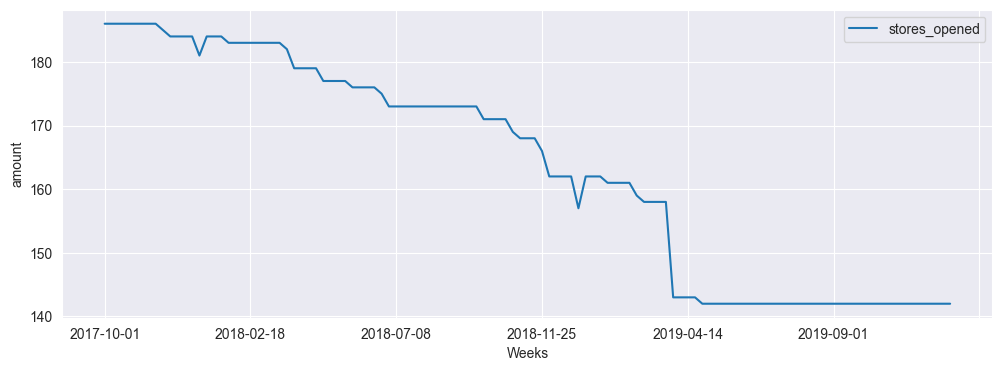

In [5]:
df_sales[['investment_tv', 'investment_radio', 'investment_press',
          'investment_banners', 'investment_online']].plot(figsize=(12,4), xlabel='Weeks', ylabel='Investment in CZK')

df_sales.plot(x='Date', y='sales', figsize=(12,4), xlabel='Weeks', ylabel='Sales in CZK')
df_sales.plot(x='Date', y='stores_opened', figsize=(12,4), xlabel='Weeks', ylabel='amount')

plt.show()

<AxesSubplot:xlabel='Weeks', ylabel='Investment in CZK'>

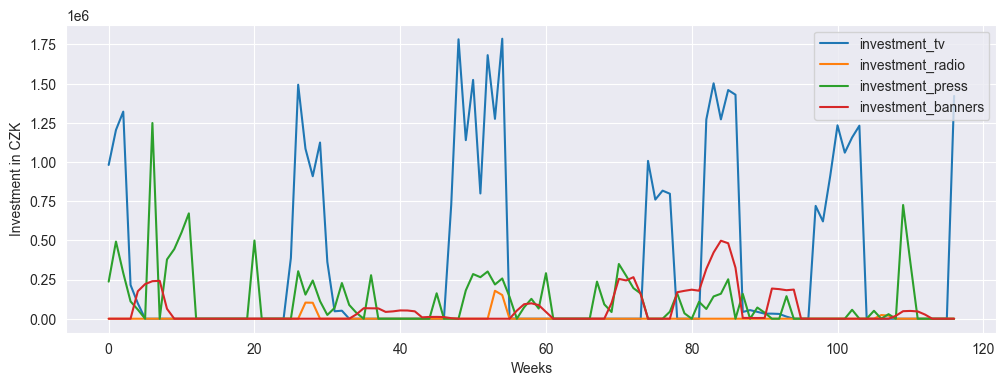

In [6]:
df_sales[['investment_tv', 'investment_radio', 'investment_press',
          'investment_banners']].plot(figsize=(12,4), xlabel='Weeks', ylabel='Investment in CZK')
# investment activities without "online"

In [7]:
df_sales[['investment_tv', 'investment_radio', 'investment_press',
          'investment_banners', 'investment_online', 'sales']].corr()['sales']

investment_tv         0.0748
investment_radio      0.1209
investment_press     -0.1792
investment_banners    0.0461
investment_online     0.0603
sales                 1.0000
Name: sales, dtype: float64

In [8]:
df_sales['christmas_dummy'].sum()

3

Ok, I don't see the connection between marketing activities and sales. But we can see a fall in sales at Christmas.

## Step 2
Now let's join two tables. I see it as two functions with different frequencies of node points. So I need to interpolate it, and then I'll know "all" points of these functions.
For now, I prefer linear interpolation, but in the future, we can use more complicated methods (like polynomial interpolation, individual for every column)

In the beginning, I need to create the common integer X-axis.

In [9]:
df_sales['Date'][[0, 116]]
# the first and the last date

0      2017-10-01
116    2019-12-22
Name: Date, dtype: object

In [10]:
first_date = date(2017, 10, 1)
last_date = date(2019, 12, 22)
delta = last_date - first_date
delta.days
# the first date will be 0 and the last date will equal 812

812

In [11]:
x_weekly_values = df_sales.Date.apply(lambda x: (datetime.strptime(x, '%Y-%m-%d').date() - first_date).days).values
x_weekly_values
# convert all date from first table into integer

array([  0,   7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
        91,  98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175,
       182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266,
       273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343, 350, 357,
       364, 371, 378, 385, 392, 399, 406, 413, 420, 427, 434, 441, 448,
       455, 462, 469, 476, 483, 490, 497, 504, 511, 518, 525, 532, 539,
       546, 553, 560, 567, 574, 581, 588, 595, 602, 609, 616, 623, 630,
       637, 644, 651, 658, 665, 672, 679, 686, 693, 700, 707, 714, 721,
       728, 735, 742, 749, 756, 763, 770, 777, 784, 791, 798, 805, 812],
      dtype=int64)

In [12]:
df_economy.Date

0     2017-01-01
1     2017-02-01
2     2017-03-01
3     2017-04-01
4     2017-05-01
5     2017-06-01
6     2017-07-01
7     2017-08-01
8     2017-09-01
9     2017-10-01
10    2017-11-01
11    2017-12-01
12    2018-01-01
13    2018-02-01
14    2018-03-01
15    2018-04-01
16    2018-05-01
17    2018-06-01
18    2018-07-01
19    2018-08-01
20    2018-09-01
21    2018-10-01
22    2018-11-01
23    2018-12-01
24    2019-01-01
25    2019-02-01
26    2019-03-01
27    2019-04-01
28    2019-05-01
29    2019-06-01
30    2019-07-01
31    2019-08-01
32    2019-09-01
33    2019-10-01
34    2019-11-01
35    2019-12-01
Name: Date, dtype: object

Ooh, I've noticed that the second table ends earlier. So I see two options.
The first is to cut last 3 points in y table (2,5% of dataset), and the second is to predict the last points in the monthly table (it means using another predicting method).

I don't like both. But the second doesn't make sense because economic indices are a bit "random" (hard to predict using only previous points).

In [13]:
# cut last 3 dates from weekly table
x_weekly_values = x_weekly_values[:-3]
x_weekly_values

array([  0,   7,  14,  21,  28,  35,  42,  49,  56,  63,  70,  77,  84,
        91,  98, 105, 112, 119, 126, 133, 140, 147, 154, 161, 168, 175,
       182, 189, 196, 203, 210, 217, 224, 231, 238, 245, 252, 259, 266,
       273, 280, 287, 294, 301, 308, 315, 322, 329, 336, 343, 350, 357,
       364, 371, 378, 385, 392, 399, 406, 413, 420, 427, 434, 441, 448,
       455, 462, 469, 476, 483, 490, 497, 504, 511, 518, 525, 532, 539,
       546, 553, 560, 567, 574, 581, 588, 595, 602, 609, 616, 623, 630,
       637, 644, 651, 658, 665, 672, 679, 686, 693, 700, 707, 714, 721,
       728, 735, 742, 749, 756, 763, 770, 777, 784, 791], dtype=int64)

In [14]:
# dates from 2017-10-1 to 2019-12-01
df_economy_short = df_economy.loc[9:]
x_monthly_values = df_economy_short.Date.apply(lambda x: (datetime.strptime(x, '%Y-%m-%d').date() - first_date).days).values
x_monthly_values

array([  0,  31,  61,  92, 123, 151, 182, 212, 243, 273, 304, 335, 365,
       396, 426, 457, 488, 516, 547, 577, 608, 638, 669, 700, 730, 761,
       791], dtype=int64)

In [15]:
unemployment_interpolated = np.interp(x_weekly_values, x_monthly_values, df_economy_short['unemployment'])
tourists_interpolated = np.interp(x_weekly_values, x_monthly_values, df_economy_short['tourists'])
gdp_interpolated = np.interp(x_weekly_values, x_monthly_values, df_economy_short['gdp'])
confidence_interpolated = np.interp(x_weekly_values, x_monthly_values, df_economy_short['confidence'])

df_economy_interpolated = pd.DataFrame({'unemployment': unemployment_interpolated,
                                        'tourists': tourists_interpolated,
                                        'gdp': gdp_interpolated,
                                        'confidence': confidence_interpolated})
df_economy_interpolated

,unemployment,tourists,gdp,confidence
0,3.6011,"926,941.0000",0.6359,114.0318
1,3.5782,"872,241.1935",0.6359,114.3951
2,3.5554,"817,541.3871",0.6359,114.7585
3,3.5326,"762,841.5806",0.6359,115.1218
4,3.5098,"708,141.7742",0.6359,115.4852
...,...,...,...,...
109,2.6103,"763,112.4000",0.3303,107.1520
110,2.6748,"787,949.8000",0.3303,107.8528
111,2.7393,"812,787.2000",0.3303,108.5537
112,2.8038,"837,624.6000",0.3303,109.2546


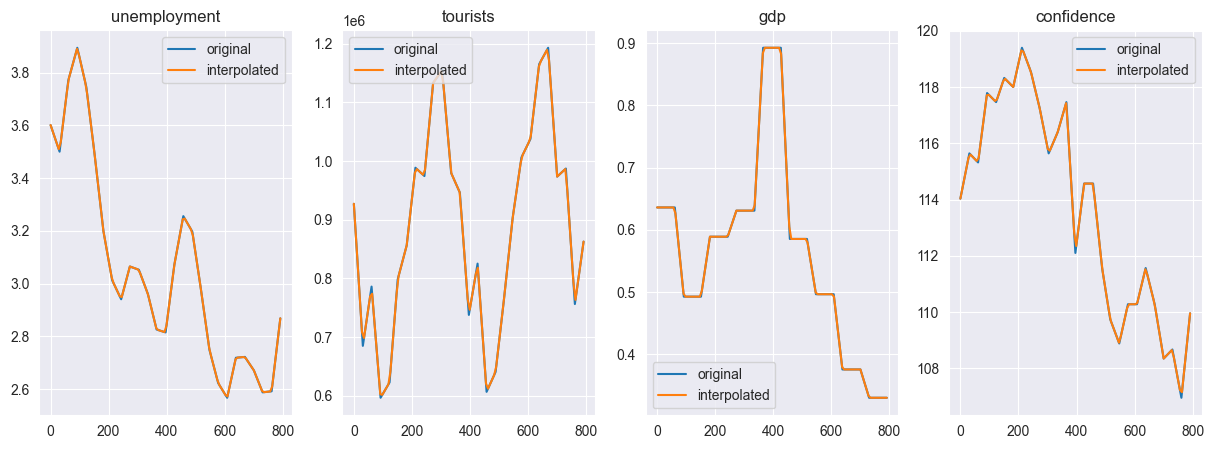

In [16]:
# let's check the results
plt.figure(figsize=(15, 5))
plt.subplot(1, 4, 1)
plt.plot(x_monthly_values, df_economy_short[['unemployment']], label='original')
plt.plot(x_weekly_values, df_economy_interpolated[['unemployment']], label='interpolated')
plt.legend()
plt.title('unemployment')

plt.subplot(1, 4, 2)
plt.plot(x_monthly_values, df_economy_short[['tourists']], label='original')
plt.plot(x_weekly_values, df_economy_interpolated[['tourists']], label='interpolated')
plt.legend()
plt.title('tourists')

plt.subplot(1, 4, 3)
plt.plot(x_monthly_values, df_economy_short[['gdp']], label='original')
plt.plot(x_weekly_values, df_economy_interpolated[['gdp']], label='interpolated')
plt.legend()
plt.title('gdp')

plt.subplot(1, 4, 4)
plt.plot(x_monthly_values, df_economy_short[['confidence']], label='original')
plt.plot(x_weekly_values, df_economy_interpolated[['confidence']], label='interpolated')
plt.legend()
plt.title('confidence')

plt.show()

# a bit predictable because matplotlib uses interpolation method for visualization
# but at least I didn't make a mistake

In [17]:
df_big = df_sales.iloc[:-3].join(df_economy_interpolated)
df_big

,Date,investment_tv,investment_radio,investment_press,investment_banners,investment_online,stores_opened,economy_index,investment_competition,public_holidays,...,investment_competition_2,precipitation_index,competitor_recognition_1,competitor_recognition_2,YearWeek,sales,unemployment,tourists,gdp,confidence
0,2017-10-01,"981,309.6270",0.0000,"236,646.2427",0.0000,"871,248.6945",186,"22,777.0000","64,817.0000",0,...,"16,467,460.9200",29.9571,0.4284,0.4398,201740,"28,760,744.5718",3.6011,"926,941.0000",0.6359,114.0318
1,2017-10-08,"1,204,435.8287",0.0000,"492,336.7872",0.0000,"780,996.4369",186,"22,905.3000","290,340.0000",0,...,"9,855,485.5160",7.3143,0.3969,0.5116,201741,"32,486,467.6282",3.5782,"872,241.1935",0.6359,114.3951
2,2017-10-15,"1,321,570.3218",0.0000,"291,885.3378",0.0000,"932,173.8794",186,"23,328.8000","824,941.0000",0,...,"18,126,310.5200",9.5000,0.4404,0.3948,201742,"33,904,425.9411",3.5554,"817,541.3871",0.6359,114.7585
3,2017-10-22,"215,521.5178",0.0000,"110,500.8320",0.0000,"683,081.4701",186,"23,485.3000","591,291.0000",1,...,"15,791,697.6300",30.4857,0.4044,0.4138,201743,"33,356,398.7235",3.5326,"762,841.5806",0.6359,115.1218
4,2017-10-29,"97,991.9200",0.0000,"58,135.3593","175,435.8015","539,848.5232",186,"23,557.1000","554,888.8674",0,...,"23,241,219.0100",19.7286,0.5003,0.4523,201744,"36,785,574.1061",3.5098,"708,141.7742",0.6359,115.4852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,2019-11-03,0.0000,0.0000,"725,726.3069","48,061.9320","885,524.6680",142,"27,774.7000","4,708,613.2510",0,...,"19,525,494.2200",15.3857,0.5182,0.4812,201945,"47,505,745.7689",2.6103,"763,112.4000",0.3303,107.1520
110,2019-11-10,0.0000,0.0000,"357,216.6918","49,755.9537","1,217,559.1043",142,"28,004.9000","4,455,255.9290",1,...,"16,368,831.6300",17.9571,0.4766,0.5346,201946,"46,037,543.0563",2.6748,"787,949.8000",0.3303,107.8528
111,2019-11-17,0.0000,0.0000,0.0000,"46,592.1206","1,304,332.2899",142,"28,090.2000","3,983,356.6480",0,...,"16,435,851.2700",10.7714,0.4022,0.4022,201947,"48,817,472.5230",2.7393,"812,787.2000",0.3303,108.5537
112,2019-11-24,0.0000,0.0000,0.0000,"26,600.5635","2,018,774.0500",142,"28,175.0000","17,469,024.9800",0,...,"22,385,049.6500",19.1000,0.5527,0.4718,201948,"46,103,942.7991",2.8038,"837,624.6000",0.3303,109.2546


Of course, there is a dependency between the economic situation and the client's income.
In most cases, usually, it's better when the economy is on top.

## Step 3

First of all, I definitely need all investment columns.
Then I would remove "christmas_dummy" because I have "public_holidays" and "weather_index" with "precipitation_index" because I don't think it may affect on marketing.
Tourist column isn't important as well because our client is oriented at local customers and I don't see connection between sales and tourist trends.

But it's just my thoughts. Let's look at the correlation between all features and sales. We might consider dropping or merging highly correlated features.

In [18]:
df_big.corr()['sales'].abs()

investment_tv              0.1062
investment_radio           0.1241
investment_press           0.1774
investment_banners         0.0513
investment_online          0.0405
stores_opened              0.6977
economy_index              0.7740
investment_competition     0.2356
public_holidays            0.2790
brand_knowledge            0.0824
christmas_dummy            0.3375
weather_index              0.4435
investment_competition_1   0.2734
investment_competition_2   0.1016
precipitation_index        0.0512
competitor_recognition_1   0.2553
competitor_recognition_2   0.2038
YearWeek                   0.7634
sales                      1.0000
unemployment               0.8112
tourists                   0.4104
gdp                        0.2342
confidence                 0.5328
Name: sales, dtype: float64

<AxesSubplot:>

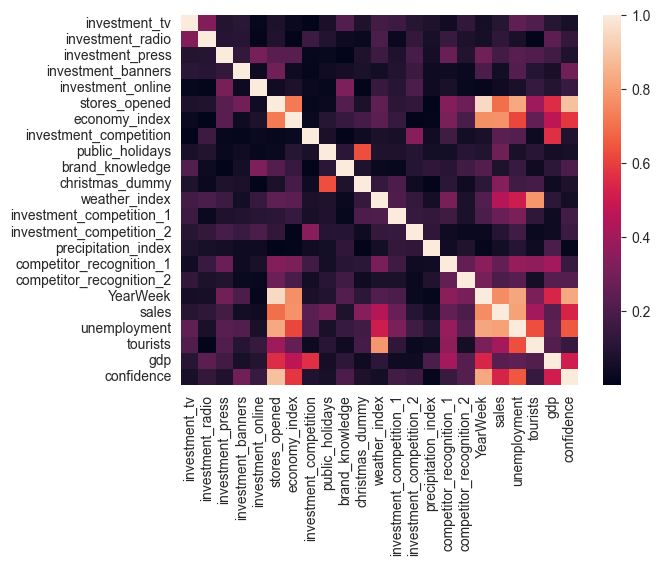

In [19]:
sns.heatmap(np.abs(df_big.corr()))

In [20]:
np.abs(df_big[['stores_opened', 'economy_index', 'weather_index',
               'unemployment', 'tourists', 'gdp', 'confidence']].corr())

,stores_opened,economy_index,weather_index,unemployment,tourists,gdp,confidence
stores_opened,1.0000,0.7208,0.2448,0.8304,0.3953,0.5582,0.8882
economy_index,0.7208,1.0000,0.2362,0.6149,0.2562,0.4690,0.5823
weather_index,0.2448,0.2362,1.0000,0.5076,0.7846,0.1218,0.0534
unemployment,0.8304,0.6149,0.5076,1.0000,0.6320,0.2465,0.6525
tourists,0.3953,0.2562,0.7846,0.6320,1.0000,0.2149,0.1481
gdp,0.5582,0.4690,0.1218,0.2465,0.2149,1.0000,0.5121
confidence,0.8882,0.5823,0.0534,0.6525,0.1481,0.5121,1.0000


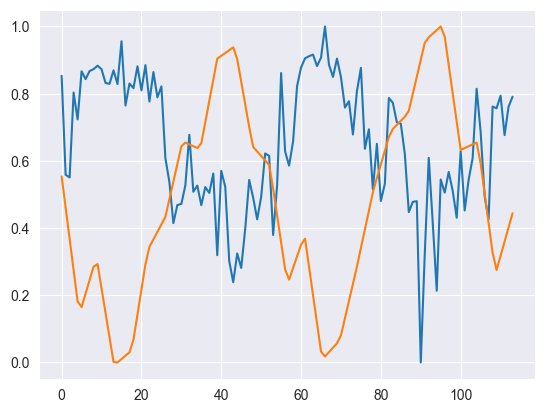

In [21]:
scaler = MinMaxScaler()
plt.plot(scaler.fit_transform(df_big[['weather_index', 'tourists']]))

<AxesSubplot:>

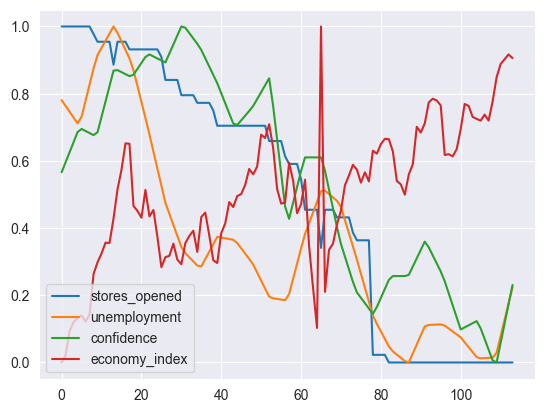

In [22]:
corr_features = ['stores_opened', 'unemployment', 'confidence', 'economy_index']
df_corr_features = pd.DataFrame(scaler.fit_transform(df_big[corr_features]), index=df_big[corr_features].index, columns=df_big[corr_features].columns)
df_corr_features.plot()

We can see that I was wrong about some features.

I removed 'brand_knowledge' and 'precipitation_index' because they don't correlate with 'sales'.

Then I found out that tourists and weather are highly correlated features.
So I will continue only with 'tourists' (I think it's more relevant to our task).

And 'stores_opened' is highly correlated with unemployment, confidence, and economy_index. Therefore, it doesn't give us additional information.

In [23]:
economy = ['unemployment', 'gdp', 'confidence', 'tourists']
competitors = ['investment_competition_1', 'investment_competition_2',
               'competitor_recognition_1', 'competitor_recognition_2', 'investment_competition']
investment = ['investment_tv', 'investment_radio',
              'investment_press', 'investment_banners', 'investment_online']
other = ['economy_index', 'public_holidays', 'sales']
selected = investment + competitors + economy + other

In [24]:
df_big[selected]

,investment_tv,investment_radio,investment_press,investment_banners,investment_online,investment_competition_1,investment_competition_2,competitor_recognition_1,competitor_recognition_2,investment_competition,unemployment,gdp,confidence,tourists,economy_index,public_holidays,sales
0,"981,309.6270",0.0000,"236,646.2427",0.0000,"871,248.6945","4,469,290.4800","16,467,460.9200",0.4284,0.4398,"64,817.0000",3.6011,0.6359,114.0318,"926,941.0000","22,777.0000",0,"28,760,744.5718"
1,"1,204,435.8287",0.0000,"492,336.7872",0.0000,"780,996.4369","3,424,971.7750","9,855,485.5160",0.3969,0.5116,"290,340.0000",3.5782,0.6359,114.3951,"872,241.1935","22,905.3000",0,"32,486,467.6282"
2,"1,321,570.3218",0.0000,"291,885.3378",0.0000,"932,173.8794","15,027,134.7500","18,126,310.5200",0.4404,0.3948,"824,941.0000",3.5554,0.6359,114.7585,"817,541.3871","23,328.8000",0,"33,904,425.9411"
3,"215,521.5178",0.0000,"110,500.8320",0.0000,"683,081.4701","11,471,088.7600","15,791,697.6300",0.4044,0.4138,"591,291.0000",3.5326,0.6359,115.1218,"762,841.5806","23,485.3000",1,"33,356,398.7235"
4,"97,991.9200",0.0000,"58,135.3593","175,435.8015","539,848.5232","18,760,937.5000","23,241,219.0100",0.5003,0.4523,"554,888.8674",3.5098,0.6359,115.4852,"708,141.7742","23,557.1000",0,"36,785,574.1061"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.0000,0.0000,"725,726.3069","48,061.9320","885,524.6680","16,891,644.2100","19,525,494.2200",0.5182,0.4812,"4,708,613.2510",2.6103,0.3303,107.1520,"763,112.4000","27,774.7000",0,"47,505,745.7689"
110,0.0000,0.0000,"357,216.6918","49,755.9537","1,217,559.1043","16,219,976.5400","16,368,831.6300",0.4766,0.5346,"4,455,255.9290",2.6748,0.3303,107.8528,"787,949.8000","28,004.9000",1,"46,037,543.0563"
111,0.0000,0.0000,0.0000,"46,592.1206","1,304,332.2899","15,994,437.9600","16,435,851.2700",0.4022,0.4022,"3,983,356.6480",2.7393,0.3303,108.5537,"812,787.2000","28,090.2000",0,"48,817,472.5230"
112,0.0000,0.0000,0.0000,"26,600.5635","2,018,774.0500","8,383,346.4830","22,385,049.6500",0.5527,0.4718,"17,469,024.9800",2.8038,0.3303,109.2546,"837,624.6000","28,175.0000",0,"46,103,942.7991"


## Step 4 and 5

I need to normalize the data since we have different distributions and scales. It may affect some machine learning algorithms later.

In [25]:
scaler = MinMaxScaler()
df_selected = pd.DataFrame(scaler.fit_transform(df_big[selected]), index=df_big[selected].index, columns=df_big[selected].columns)
df_selected

,investment_tv,investment_radio,investment_press,investment_banners,investment_online,investment_competition_1,investment_competition_2,competitor_recognition_1,competitor_recognition_2,investment_competition,unemployment,gdp,confidence,tourists,economy_index,public_holidays,sales
0,0.5492,0.0000,0.1895,0.0000,0.1379,0.1491,0.5114,0.3170,0.5253,0.0025,0.7808,0.5438,0.5662,0.5538,0.0000,0.0000,0.0000
1,0.6741,0.0000,0.3942,0.0000,0.1212,0.1097,0.3023,0.1808,0.7757,0.0113,0.7634,0.5438,0.5961,0.4608,0.0218,0.0000,0.1858
2,0.7396,0.0000,0.2337,0.0000,0.1492,0.5476,0.5639,0.3689,0.3683,0.0320,0.7461,0.5438,0.6260,0.3678,0.0937,0.0000,0.2565
3,0.1206,0.0000,0.0885,0.0000,0.1031,0.4134,0.4900,0.2133,0.4345,0.0229,0.7288,0.5438,0.6559,0.2748,0.1203,0.3333,0.2291
4,0.0548,0.0000,0.0465,0.3524,0.0765,0.6886,0.7257,0.6279,0.5688,0.0215,0.7115,0.5438,0.6858,0.1818,0.1325,0.0000,0.4001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.0000,0.0000,0.5810,0.0966,0.1405,0.6180,0.6081,0.7051,0.6696,0.1826,0.0288,0.0000,0.0000,0.2752,0.8488,0.0000,0.9346
110,0.0000,0.0000,0.2860,0.1000,0.2020,0.5927,0.5083,0.5252,0.8557,0.1727,0.0778,0.0000,0.0577,0.3175,0.8879,0.3333,0.8614
111,0.0000,0.0000,0.0000,0.0936,0.2180,0.5841,0.5104,0.2038,0.3942,0.1544,0.1268,0.0000,0.1154,0.3597,0.9024,0.0000,1.0000
112,0.0000,0.0000,0.0000,0.0534,0.3503,0.2969,0.6986,0.8543,0.6369,0.6773,0.1757,0.0000,0.1730,0.4019,0.9168,0.0000,0.8647


## Step 6

I have to come up with a function that grows non-linearly and fits my domain of function (I have values from 0 to 1).
I've compared log(x+1), ln(x+1), sqrt(x), x^(1/n) to linear function and finally chose __sqrt(x)__.

At the interview, I heard that advertising has a delayed effect.
So I want to add one more transformation function containing this factor.

In [26]:
def adstock_transform(data, weeks=8, alpha=0.5):
    weights = np.power(alpha, np.arange(weeks+1))
    data_transformed = convolve(np.sqrt(data), weights)[:-weeks]
    # normalization and applying np.sqrt
    return np.sqrt(data_transformed / np.sum(weights))

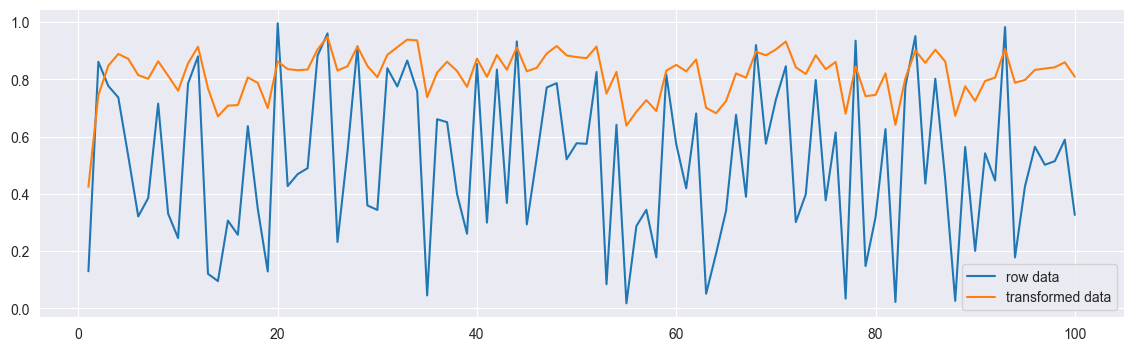

In [27]:
# It's just a test that my transformation works well
n = 100
x = np.linspace(1,n,n)
data_test = np.random.random(n)
plt.figure(figsize=(14,4))
plt.plot(x, data_test, label='row data')
plt.plot(x, adstock_transform(data_test), label='transformed data')
plt.legend()

<AxesSubplot:>

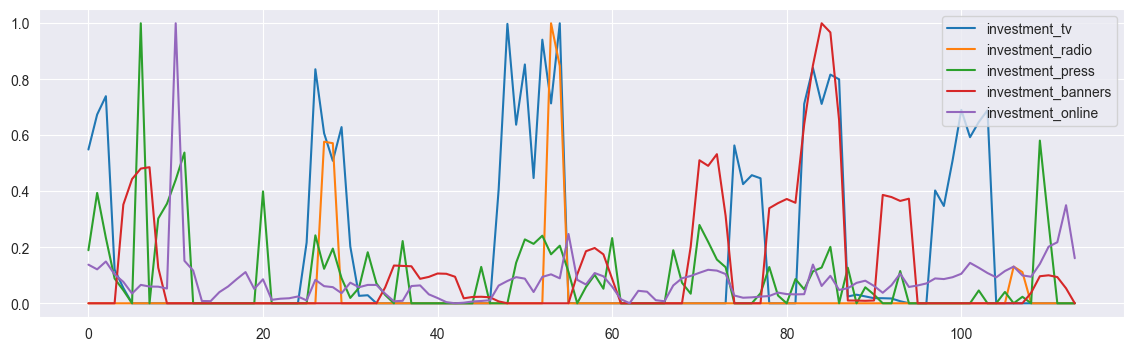

In [28]:
df_selected[investment].plot(figsize=(14,4))

<AxesSubplot:>

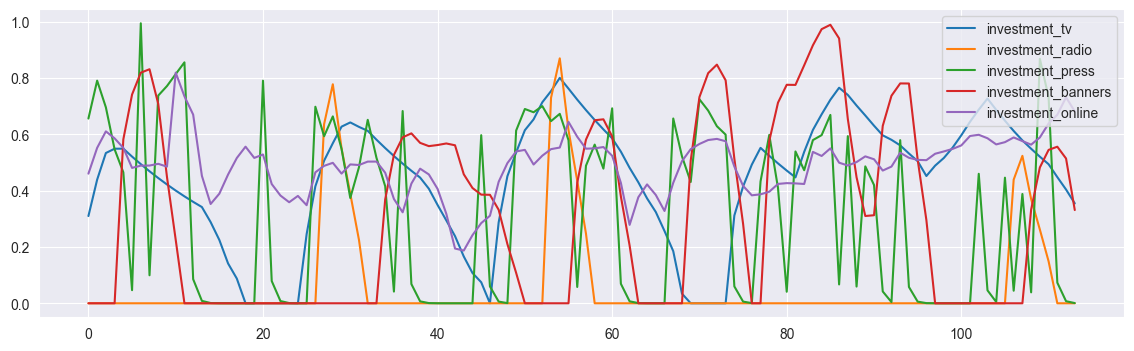

In [29]:
df_selected['investment_tv'] = adstock_transform(df_selected['investment_tv'], weeks=13, alpha=0.9)
df_selected['investment_radio'] = adstock_transform(df_selected['investment_radio'], weeks=3)
df_selected['investment_press'] = adstock_transform(df_selected['investment_press'], weeks=4, alpha=0.01)
df_selected['investment_online'] = adstock_transform(df_selected['investment_online'], weeks=2)
df_selected['investment_banners'] = adstock_transform(df_selected['investment_banners'], weeks=2)

df_selected[investment].plot(figsize=(14,4))
# media after adstock transformation

## Step 7

For this task, I would apply a standard __linear regression model__


In [30]:
df_selected

,investment_tv,investment_radio,investment_press,investment_banners,investment_online,investment_competition_1,investment_competition_2,competitor_recognition_1,competitor_recognition_2,investment_competition,unemployment,gdp,confidence,tourists,economy_index,public_holidays,sales
0,0.3100,0.0000,0.6564,0.0000,0.4606,0.1491,0.5114,0.3170,0.5253,0.0025,0.7808,0.5438,0.5662,0.5538,0.0000,0.0000,0.0000
1,0.4392,0.0000,0.7911,0.0000,0.5523,0.1097,0.3023,0.1808,0.7757,0.0113,0.7634,0.5438,0.5961,0.4608,0.0218,0.0000,0.1858
2,0.5340,0.0000,0.6963,0.0000,0.6109,0.5476,0.5639,0.3689,0.3683,0.0320,0.7461,0.5438,0.6260,0.3678,0.0937,0.0000,0.2565
3,0.5492,0.0000,0.5471,0.0000,0.5861,0.4134,0.4900,0.2133,0.4345,0.0229,0.7288,0.5438,0.6559,0.2748,0.1203,0.3333,0.2291
4,0.5494,0.0000,0.4654,0.5824,0.5523,0.6886,0.7257,0.6279,0.5688,0.0215,0.7115,0.5438,0.6858,0.1818,0.1325,0.0000,0.4001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.5209,0.2620,0.8687,0.4826,0.5893,0.6180,0.6081,0.7051,0.6696,0.1826,0.0288,0.0000,0.0000,0.2752,0.8488,0.0000,0.9346
110,0.4942,0.1491,0.7328,0.5451,0.6387,0.5927,0.5083,0.5252,0.8557,0.1727,0.0778,0.0000,0.0577,0.3175,0.8879,0.3333,0.8614
111,0.4483,0.0000,0.0733,0.5564,0.6699,0.5841,0.5104,0.2038,0.3942,0.1544,0.1268,0.0000,0.1154,0.3597,0.9024,0.0000,1.0000
112,0.4042,0.0000,0.0073,0.5145,0.7320,0.2969,0.6986,0.8543,0.6369,0.6773,0.1757,0.0000,0.1730,0.4019,0.9168,0.0000,0.8647


In [31]:
X, y = df_selected.drop(['sales'], axis=1), df_selected.sales
linear_model = LinearRegression()
linear_model.fit(X, y)
linear_model.score(X, y)

0.8774780191279702

In [32]:
coefficients = pd.DataFrame(linear_model.coef_, index=linear_model.feature_names_in_)
coefficients
# coefficients of model below

,0
investment_tv,0.0074
investment_radio,0.1088
investment_press,-0.0403
investment_banners,0.0385
investment_online,0.1699
investment_competition_1,-0.0000
investment_competition_2,-0.0434
competitor_recognition_1,-0.1480
competitor_recognition_2,0.0646
investment_competition,-0.0078


In [33]:
# test if there are linear relationships between these variables at the level of significance equals 2.5%
est = sm.OLS(y, sm.add_constant(X))
p_values = est.fit().pvalues
p_values.loc[p_values / 2 < 0.025]
# (p-values / 2) that are less than 2.5% below

const                      0.0000
investment_radio           0.0239
competitor_recognition_1   0.0007
unemployment               0.0000
confidence                 0.0004
tourists                   0.0260
economy_index              0.0000
public_holidays            0.0000
dtype: float64

## Step 8

That's a bit unexpected.
The model says that investment in press has a negative influence. Other negative coefficients make sense (except GDP).

According to this model, __online investments are the most efficient__.

To be sure that my model is statistically valid I calculated __p-values__.
At the __0.025__ level of significance there are only few relationships statistically valid

In any case, the model has to be improved. I need to adjust the coefficients in the adstock function.
I think this is the reason of negative coefficient for press investment.

## Step 9

- compare my model with other models
- test model on completely new data
- compute error (R^2)

## Step 10

I would start by showing a chart comparing the effectiveness for each marketing channel. I would show that there is a big difference between the channels.
Then suggested a new distribution of money (step 12).


## Step 11

Every contribution consists of the amount of spent money and the efficiency of the marketing channel.
Therefore, contribution equals linear coefficient for chanel times spent money(transformed by adstock_transform).



In [34]:
spent_money = df_selected[investment].sum(axis=0)
contribution =  pd.concat([spent_money, coefficients.iloc[:5, :]], axis=1)
contribution.columns = ['money', 'coefficients']
contribution['contribution'] = (spent_money.values * coefficients.iloc[:5, :].values.T).T
contribution

,money,coefficients,contribution
investment_tv,49.8917,0.0074,0.3714
investment_radio,7.2230,0.1088,0.7858
investment_press,35.8912,-0.0403,-1.4463
investment_banners,35.2799,0.0385,1.3583
investment_online,56.0921,0.1699,9.5287


## Step 12

Finding the best marketing mix looks like optimization problem.

I see it like:

- max sum(y_i)
- y_i = dot(beta, x_i)
- x_i > 0

y_i - sales in i-th week
x_i - vector of spending on every media and others features
beta - linear coefficient for every media and every feature
